# Import Library and Data

In [46]:
## Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##Text Preprocessing
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords

## Models and utils
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
stopword = set(stopwords.words('english'))

import warnings
warnings.filterwarnings('ignore')


import nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [47]:
tweets = pd.read_csv("./train_data.csv")

In [48]:
tweets.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [49]:
tweets.shape

(7920, 3)

In [50]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
id       7920 non-null int64
label    7920 non-null int64
tweet    7920 non-null object
dtypes: int64(2), object(1)
memory usage: 185.8+ KB


# EDA

In [51]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

word_freq = gen_freq(tweets.tweet.str)

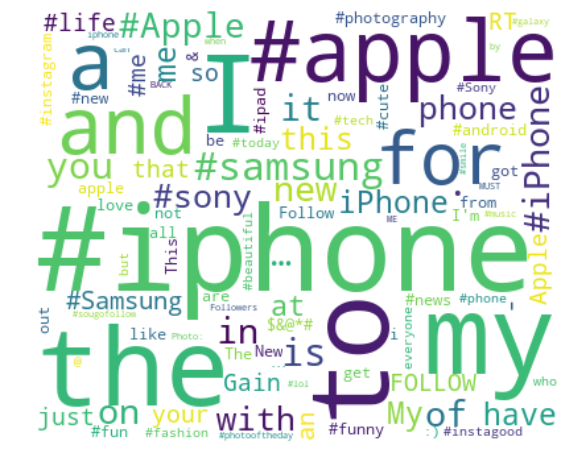

In [52]:
#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Cleaning and preprocessing

In [53]:
def clean_text(text):
    
    text = re.sub(r'[$&@*#]', '', text)
    
    text = re.sub(r'RT', '', text)
    
    text = re.sub(r'http[s]*://[\w./]+', '', text)
    
    text = re.sub(r'[^\w\s]', '', text)
      
    text = text.lower()
    
    return text

clean_text(tweets.tweet[1])
    

'finally a transparant silicon case  thanks to my uncle  yay sony xperia s sonyexperias '

In [54]:
tweets["cleaned_tweet"] = tweets.tweet.apply(clean_text)

In [55]:
tweets["cleaned_tweet"] = tweets["cleaned_tweet"].apply(lambda x: " ".join([t for t in x.split() if t not in stopword]))

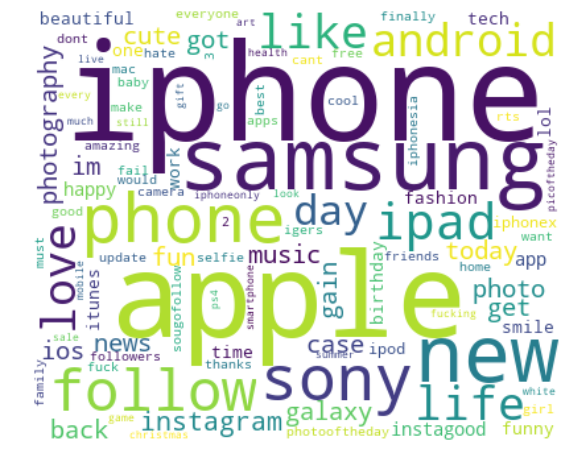

In [11]:
words_freq_1 = gen_freq(tweets["cleaned_tweet"].str)

#Import libraries

from wordcloud import WordCloud

#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(words_freq_1)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Model Building

In [12]:
print(simple_preprocess(tweets["cleaned_tweet"][1]))

['finally', 'transparant', 'silicon', 'case', 'thanks', 'uncle', 'yay', 'sony', 'xperia', 'sonyexperias']


In [13]:
tweets.cleaned_tweet

0       fingerprint pregnancy test android apps beauti...
1       finally transparant silicon case thanks uncle ...
2       love would go talk makememories unplug relax i...
3       im wired know im george made way iphone cute d...
4       amazing service apple wont even talk question ...
                              ...                        
7915    live loud lol liveoutloud selfie smile sony mu...
7916    would like wish amazing day make every minute ...
7917    helping lovely 90 year old neighbor ipad morni...
7918    finally got smart pocket wifi stay connected a...
7919    apple barcelona apple store bcn barcelona trav...
Name: cleaned_tweet, Length: 7920, dtype: object

In [14]:
preprocessed_tweets = tweets.cleaned_tweet.apply(lambda x: simple_preprocess(x))

In [15]:
# import word2vec
from gensim.models import Word2Vec

# train a word2vec model from the given data set
w2v_model = Word2Vec(preprocessed_tweets, size=200, min_count=2, sg=1)

In [16]:
# vocabulary size
print('vocabulary size:', len(w2v_model.wv.vocab))

vocabulary size: 6023


In [17]:
# get trained embedding of the word 'warning'
print('shape of \'warning\' vector:', w2v_model.wv.get_vector('warning').shape)

shape of 'warning' vector: (200,)


In [56]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_w2v(doc_tokens, pre_trained):
    embeddings = []
    # if pre_trained = 1; use Google's model else use our own model
    if pre_trained:
        model = w2vec
    else:
        model = w2v_model
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in model.wv.vocab:
            embeddings.append(model.wv.word_vec(tok))
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

In [19]:
import pickle

with open('../../Word_Embeddings_in_Action_-_GloVe/Word Embeddings in Action - GloVe/glove.6B.300d.pkl', 'rb') as fp:
    # load glove from disk 
    glove = pickle.load(fp)

In [20]:
# returns vector reperesentation of a given word if it is present in vocabulary
def get_embedding_glove(doc_tokens):
    embeddings = []
    # iterate over tokens to extract their vectors    
    for tok in doc_tokens:
        if tok in glove:
            embeddings.append(glove[tok])
    # mean the vectors of individual words to get the vector of the statement
    return np.mean(embeddings, axis=0)

In [57]:
tweets.at[3391, "cleaned_tweet"] =  "moapp Me too! Me too! Me too! Me too! Me too! Me too! Me too! Me too!"

In [58]:
test = pd.read_csv("./test_data.csv")

# Pipeline

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextPreprocessing(BaseEstimator, TransformerMixin ):
    
    def __init__(self, is_preprocess = True):
        self.is_preprocess = is_preprocess;

    def fit(self, x_dataset, y=None):
        return self

    def transform(self, x_dataset, y=None):
        if self.is_preprocess :
            x_dataset["cleaned_tweet"] = x_dataset["tweet"].apply(clean_text)
            x_dataset["cleaned_tweet"] = x_dataset["cleaned_tweet"].apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
            #preprocessed_tweets = x_dataset.cleaned_tweet.apply(lambda x: simple_preprocess(x))

            # create X from glove
            X = x_dataset["cleaned_tweet"].apply(lambda x: get_embedding_w2v(x,0))
            X = pd.DataFrame(X.tolist())
        else :
            X = x_dataset
        return X

In [61]:
tweets["cleaned_tweet"] = tweets["tweet"].apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

model_pipeline = Pipeline(steps=[('Text_Preprocessing', TextPreprocessing()), 
                                 ('random_forest', GradientBoostingClassifier(learning_rate=0.1, n_estimators=200))
                                 ])

train_x = tweets[["tweet"]]
train_y = tweets[["label"]]


X_train, X_test, y_train, y_test = train_test_split( train_x, train_y , test_size = 0.2 , random_state = 42 )
# fit the pipeline with the training data
model_pipeline.fit(X_train,y_train)
pred_y =model_pipeline.predict(X_test)
f1_score(y_test, pred_y)

0.7789473684210526

In [83]:
def preprocess_train_Data(x_Train_Data):
    x_Train_Data["cleaned_tweet"] = x_Train_Data["tweet"].apply(clean_text)
    x_Train_Data["cleaned_tweet"] = x_Train_Data["cleaned_tweet"].apply(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
    #preprocessed_tweets = x_Train_Data.cleaned_tweet.apply(lambda x: simple_preprocess(x))
    
    # create X from glove
    X = x_Train_Data["cleaned_tweet"].apply(lambda x: get_embedding_w2v(x,0))
    X = pd.DataFrame(X.tolist())
    return X

In [67]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('Text_Preprocessing', TextPreprocessing()), 
                                 ('random_forest', classifier)
                                 ])
    pipe.fit(X_train, y_train)   
    print(classifier)
    y_pred = pipe.predict(X_test)
    print("model score: %.3f" % f1_score(y_test, y_pred))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')
model score: 0.742
SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
model score: 0.000
NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
   kernel='rbf', max_iter=-1, nu=0.5, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)
model score: 0.552
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=Fal

In [88]:
train_data = pd.read_csv("./train_data.csv")
x_Train_Data  = train_data[["tweet"]]
y_Train_Data  = train_data[["label"]]
pipe_GB = Pipeline(steps=[('Text_Preprocessing', TextPreprocessing()), 
                                 ('random_forest', AdaBoostClassifier(n_estimators=250, learning_rate=0.1 ))
                                 ])
pipe_GB.fit(x_Train_Data, y_Train_Data)
pred_test = pipe_GB.predict(test[["tweet"]])
test["label"] = pred_test
test.to_csv("sub_using_GloVe.csv", columns=["id","label"], index=False)

In [ ]:
# pipe_GB = Pipeline(steps=[('Text_Preprocessing', TextPreprocessing(is_preprocess = False)), 
#                                  ('GradientBoostingClassifier', GradientBoostingClassifier())
#                                  ])
# param_grid = { 
#     'GradientBoostingClassifier__learning_rate': [0.1],
#     'GradientBoostingClassifier__n_estimators': [100],
# }

# from sklearn.model_selection import GridSearchCV
    
# CV = GridSearchCV(pipe_GB, param_grid, n_jobs= -1, scoring= 'f1_micro')
                  
# CV.fit(train_x, train_y)  
# print(CV.best_params_)    
# print(CV.best_score_)

In [ ]:
test["label"] = pred_test

In [ ]:
test.to_csv("sub_using_GloVe.csv", columns=["id","label"], index=False)

In [70]:
# Helper Class for Initilizing GridSearch

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
        self.best_params = {}
        self.feature_importance = {}
        self.FeatureImportanceAlgo = ['DecisionTreeClassifier','RandomForestClassifier','ExtraTreesClassifier','GradientBoostingClassifier']

    def fit(self, X, y, cv=3, n_jobs=-1, verbose=1, scoring='f1', refit=True):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs  
            self.best_params[key]  = str(gs.best_params_)
            if key in self.FeatureImportanceAlgo:
              self.feature_importance[key]= gs.best_estimator_ .feature_importances_

            # print (gs.best_params_.feature_importances_ )
            # try:
            #   print(gs.best_params_.feature_importances_ )
            #   self.feature_importance[key]= gs.best_params_.feature_importances_ 
            # except AttributeError:
            #   pass

    def returnBestParamDF(self):
        
        d = self.best_params
        BestParamDF = pd.DataFrame.from_dict([d.keys(), d.values()]).T
        return BestParamDF

        # def Feature_Importance(self):
        #   for each

        # def returnFeatureImportance(self):


    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

models1 = {
    
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassfier':AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier()
}

params1 = {
    'GradientBoostingClassifier': { 'n_estimators': [100], 'learning_rate': [0.2] },
    'AdaBoostClassfier' : { 'n_estimators': [150,200,250,300], 'learning_rate': [0.3,0.2,0.1]},
    'RandomForestClassifier' : {'n_estimators': [200,250,300], },
    'KNeighborsClassifier' :{'n_neighbors': [3,5,7]}
}


In [84]:
tweetS_Train = pd.read_csv("./train_data.csv")
train_x = preprocess_train_Data(tweetS_Train)
train_y = tweetS_Train[["label"]]

In [86]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(train_x, train_y, scoring='f1', n_jobs=-1)

Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.1s finished


Running GridSearchCV for AdaBoostClassfier.
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  7.4min finished


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   37.1s remaining:   46.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.0min finished


Running GridSearchCV for KNeighborsClassifier.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   19.6s remaining:   24.5s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   33.7s finished


In [87]:
helper1.score_summary(sort_by='mean_score')

GradientBoostingClassifier
AdaBoostClassfier
RandomForestClassifier
KNeighborsClassifier


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators,n_neighbors
11,AdaBoostClassfier,0.755839,0.759161,0.763402,0.00315557,0.1,250,NaN
10,AdaBoostClassfier,0.753783,0.757065,0.760885,0.00292434,0.1,200,NaN
12,AdaBoostClassfier,0.751412,0.756237,0.760057,0.00360006,0.1,300,NaN
9,AdaBoostClassfier,0.752584,0.75613,0.76,0.00303607,0.1,150,NaN
14,RandomForestClassifier,0.7473,0.7547,0.758982,0.00525407,NaN,250,NaN
13,RandomForestClassifier,0.750357,0.75469,0.762622,0.00561693,NaN,200,NaN
7,AdaBoostClassfier,0.753228,0.75441,0.755927,0.0011272,0.2,250,NaN
5,AdaBoostClassfier,0.75053,0.754169,0.757835,0.0029822,0.2,150,NaN
6,AdaBoostClassfier,0.749471,0.75406,0.757337,0.00334262,0.2,200,NaN
15,RandomForestClassifier,0.744928,0.753164,0.758974,0.0059855,NaN,300,NaN


In [ ]:
helper1.score_summary(sort_by='mean_score')

In [ ]:
helper1.score_summary(sort_by='mean_score')